<a href="https://colab.research.google.com/github/qml219/CV02_finalproj/blob/main/AlexNet_polyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table><tr><td>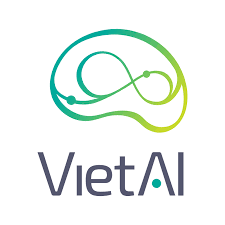</td><td><H1><font color="blue">Assignment 02: Lung Nodule Segmentation (Pytorch Version)</font></H1></td></tr></table>

<hr>

* Lớp: Computer Vision and Applications - CV02
* Tổ chức: VietAI
* Mô tả: Trong bài tập này chúng ta sẽ tiến hành xây dựng một mô hình UNET cơ bản để phân đoạn các khối u phổi (Lung nodule) với tập dữ liệu Decathlon Lungs dataset.

<b>Gợi ý:</b>

Để hoàn thiện bài tập các bạn bạn hãy điền vào những dòng code bị thiếu tại các mục Todo. Lưu ý, điểm đánh giá không chỉ phụ thuộc vào mức độ hoàn thiện của bài tập mà còn dựa trên ý tưởng của giải pháp và kỹ thuật áp dụng của các bạn.

Trên Colab bạn nên dùng cpu thì hoàn thiện các yêu cầu về tiền xử lý, định nghĩa mô hình,... Sau khi thoàn thành, hãy kích hoạt chạy với GPU để train mô hình để tiết kiệm quota tính toán và không phí GPU trong lúc không cần tới.

Bài mẫu này chạy trên V100 16G, 8 core cpu và high-ram 50G do đó mô hình có thể train trên batch-size 64 và number worker là 8. Nếu bạn dùng tài khoản miễn phí, bạn có thể train trên T4, tuy nhiên tốc độ sẽ khác chậm do số lượng core cpu chỉ là 2.

Trong bài tập này chúng ta sẽ sử dụng độ đo IOU để đánh giá chất lượng phân đoạn các nốt phổi trên ảnh CT phổi. Kết quả mô hình của bài mẫu trên lập val tương ứng là 0.9059 và trên tập test là 0.8785. Bên cạnh tiêu chí đánh giá phương pháp và coding, kết quả mô hình của bạn trên tập test cũng là một tiêu chí đánh giá quan trọng.  

<b>Thông tin Sinh viên/ Học viên:</b>
- Tên: Lê Minh Quân
- Email: qml2@case.edu
- Phone: 2166734970

<b>Mô tả phương pháp cải tiến nâng cao của bạn:</b>

Mô tả phương pháp tại đây....

<hr>

#BƯỚC 01: THIẾT LẬP MÔI TRƯỜNG

### Kiểm tra GPU


In [ ]:
#Trong bài tập này chúng ta cần xử dụng GPU để huấn luyện môn hình (Khuyến nghị các bạn sử dụng V100 để train nhanh hơn).
#Trong thời gian đầu các bạn nên chỉ sử dụng cpu để viết code, chỉ kích hoạt GPU khi đã thực hiện giai đoạn train mô hình.
!nvidia-smi

Wed Apr 10 05:01:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Tải tập dữ liệu Decathlon Lung Nodule

In [ ]:
import zipfile,os
#Bạn có thể download dataset từ https://drive.google.com/file/d/1nMCVHgiAdnw1Sq3PiYsX2QVk_wO7rE5U/view?usp=sharing

#Hoặc download bằng cách chạy đoạn code này
#(Nếu có lỗi 'Too many users have viewed or downloaded this file recently...' hãy download dataset bằng tay vì file quá lớn nên bị hạn chế từ google).
#Mặc định file sẽ được download và giải nén tại thư mục /content/ trên máy ảo trên Colab.

!gdown https://drive.google.com/uc?id=1nMCVHgiAdnw1Sq3PiYsX2QVk_wO7rE5U

database_zipfile="Decathlon_LungNoduleDataset.zip"
with zipfile.ZipFile(f"./{database_zipfile}", 'r') as zip_ref:
    zip_ref.extractall("./")
os.remove(f"./{database_zipfile}")
print("Copying Decathlon lung nodule dataset is done: " + os.getcwd())

Downloading...
From (original): https://drive.google.com/uc?id=1nMCVHgiAdnw1Sq3PiYsX2QVk_wO7rE5U
From (redirected): https://drive.google.com/uc?id=1nMCVHgiAdnw1Sq3PiYsX2QVk_wO7rE5U&confirm=t&uuid=a215dd11-a611-4644-89d5-8e5337a4f428
To: /content/Decathlon_LungNoduleDataset.zip
100% 9.11G/9.11G [02:38<00:00, 57.4MB/s]
Copying Decathlon lung nodule dataset is done: /content


### Cài đặt một số thư viện cần thiết nếu cần

In [ ]:
!pip install celluloid        #Chúng ta cần thư viện này để visualize dữ liện khối 3D ở dạng video

### Khai báo sử dụng một số thư viện cần thiết

In [ ]:
from __future__ import absolute_import, division, print_function
#%matplotlib notebook

import glob
import os
from os import path
import shutil
from pathlib import Path              #Xử lý đường dẫn
import nibabel as nib                 #Xử lý định dạng NIfTI
from celluloid import Camera          #Hiển thị 3D volume
from tqdm.notebook import tqdm        #Hiện thanh tiến trình
import re                             #Biểu thức chính quy (Regular expression)

import zipfile                        #Giải nén file zip
import json                           #Đọc file json
from copy import deepcopy

import numpy as np                    #Đại số tuyến tính (linear algebra)
import pandas as pd                   #Xử lý dataset, file CSV
import argparse
import random
from scipy import misc
from skimage import draw

from sklearn.model_selection import train_test_split             #Chia tập dữ liệu train & val
from sklearn.metrics import jaccard_score

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision
from fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import HTML
import cv2
import time

#Tăng cường dữ liệu
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

print('Importing... done!')

Importing... done!


### Thiết lập một số các tham số quan trọng để chạy mô hình


In [ ]:
cfg={
  "DIR_IMAGE": "./Decathlon_LungNoduleDataset/imagesTr",           # Thư mục chứa dữ liệu 3D của phổi, lưu trữ ở định dạng NIfTI
  "DIR_LABEL": "./Decathlon_LungNoduleDataset/labelsTr",           # Thư mục chứa nhãn chú thích của phổi, lưu trữ ở định dạng NIfTI
  "DIR_PREPROCESS": "./Decathlon_LungNoduleDataset/Preprocessed",  # Thư mục chứa ảnh tiền xử lý của ảnh phổi

  "IMAGE_SIZE": 256,                              # Kích thước đầu vào của ảnh khi training và validating
  "IMAGE_SIZE_TEST": 256,                         # Kích thước đầu vào của ảnh khi testing
  "NORMALIZATION":True,
  "NORMALIZATION_VALUE": 3071,                    # Mean of ImageNet dataset (sử dụng để normalize)
  "BATCH_SIZE": 64,
  "NUM_WORKER": 8,
  "LEARNING_RATE": 0.0002,
  "MAX_EPOCHS": 20,                              # Số lượng epoch tối đa
  "Optimizer": "ADAM",

  "LR_SCHEDULER": "MultistepLR",           #Có thể chọn các giá trị sau : "ReduceLROnPlateau",  "MultiStepLR", "LinearLR" phụ thuộc vào TODO 1:

  ##### TODO 1: Bên dưới là cấu hình cho lập lịch LR_SCHEDULER giảm lr theo cơ chế ReduceLROnPlateau, hãy mở rộng có thể tích hợp nhiều cơ chế tuỳ chọn khác, lưu ý cần bổ xung code ở Bước 5               ######
  #Mặc định bên dưới là "LR_SCHEDULER": "ReduceLROnPlateau", mô hình sẽ chạy bình thường theo cấu hình này, viết thêm khả năng có thể chọn các kiểu lập lịch khác như:MultiStepLR, LinearLR                 ######
  #Tham khảo MultiStepLR: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html, LinearLR: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html   ######

  # BEGIN SOLUTION
    # Drops learning rate by a factor of gamma once the current number of epochs exceeds each milestone - 6, 7, 7
    "MultistepLR": {
      "milestones": [7, 14],
      "gamma": 0.1,
    },
  # END SOLUTION

  # "ReduceLROnPlateau": {
  #   "LEARNING_RATE_SCHEDULE_FACTOR": 0.1,           # Parameter cho reducing learning rate
  #   "LEARNING_RATE_SCHEDULE_PATIENCE": 5,           # Parameter cho reducing learning rate
  # },
}

#BƯỚC 02: TÌM HIỂU VÀ TIỀN XỬ LÝ DỮ LIỆU CHO TẬP DỮ LIỆU DECATHON LUNG NODULE

### Mô tả dữ liệu
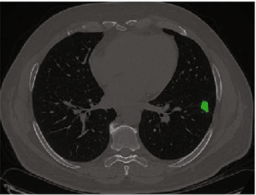
<br/>
*  Tập dữ liệu Decathlon Lung Nodule bao gồm 96 ảnh 3D về phổi, được lưu trữ ở định đang NIfTI trong thư mục imagesTr

*  Nhãn của 96 ảnh 3D về phổi chứa trong thư mục labelsTr, chứa thông tin mask của các Lung nodule (Những nốt, u phổi có nguy cơ dẫn đến ung thư)

*  Lưu ý sự khác biệt giữa định đang NIfTI và DICOM là: Với các tệp NIfTI, hình ảnh và dữ liệu khác được lưu trữ ở định dạng 3D. Nó được thiết kế đặc biệt theo cách này để vượt qua những thách thức về định hướng không gian của các định dạng tệp hình ảnh y tế khác. Mặt khác, các tệp hình ảnh DICOM và dữ liệu liên quan được tạo thành từ các lớp 2D.




### Hiển thị một ảnh lát cắt phổi và mặt nạ nhãn tương ứng của nó

(512, 512, 304) (512, 512, 304)
The orientation:('L', 'A', 'S')


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp6eysdfat/temp.m4v']' returned non-zero exit status 255.

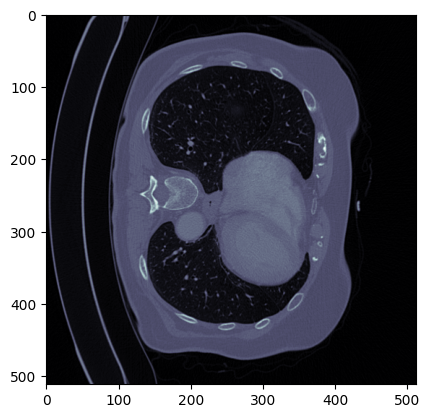

In [ ]:
#Hiển thị dữ liệu cho lung_001
sample_path = cfg['DIR_IMAGE']+"/lung_001.nii.gz"
sample_path_label = cfg['DIR_LABEL']+"/lung_001.nii.gz"

#Load tập tin data và mask của phổ ở định dạng NIfTI and trích xuất thông tin
data = nib.load(sample_path)
label = nib.load(sample_path_label)
ct = data.get_fdata()
mask = label.get_fdata()

#Chúng ta nên kiểm tra hướng của hình ảnh NIfTI, để hiểu không gian toạ độ về hương, hãy tham khảo tại: http://www.grahamwideman.com/gw/brain/orientation/orientterms.html
print(f"The orientation:{nib.aff2axcodes(data.affine)}")

fig = plt.figure()
camera = Camera(fig)  # Tạo camera object từ celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")

    camera.snap()  # Tạo slice hiện tại
animation = camera.animate()  # Tạo ảnh động

#chuyển đổi hình ảnh động thành video
HTML(animation.to_html5_video())


###Tiền xử lý dữ liệu

1) Hình ảnh CT có ngưỡng giá trị cố định từ -1000 đến 3071. Do đó chúng ta có thể chuẩn hóa bằng cách chia cho 3071 và chúng ta không cần tính giá trị trung bình và độ lệch chuẩn cho bài tập này.

2) Vì muốn tập trung vào các khối u phổi, chúng ta có thể cắt bỏ các phần của vùng bụng dưới để giảm độ phức tạp và giúp train mô hình dễ dàng hơn. Ví dụ: bạn có thể bỏ qua 30 lát đầu (từ bụng dưới đến cổ) (trục toạ độ cuối của khối dữ liệu CT).

3) Vì chúng tôi muốn giải quyết nhiệm vụ này ở cấp độ lát cắt (2D) chứ không phải ở cấp độ (3D) để giảm chi phí tính toán, bạn nên lưu trữ dữ liệu được xử lý trước dưới dạng tệp 2d, vì đọc một lát cắt nhanh hơn nhiều so với tải toàn bộ khối dữ liệu 3D từ tập tin NIfTI.

Thực hiện tiền xử lý cho tất cả các tập tin NIfTI. Chúng ta cũng cần tạo một cấu trúc thư mục lưu trữ các cắt lát ct (slice) và nhãn (mask) phù hợp. Có thể lưu ở dạng là ảnh 1 kênh graycale, hay lưu ở dạng npy.

Cấu trúc khuyến nghị trong bài này là:

./Decathlon_LungNoduleDataset/Preprocessed/images/lung_001/0.npy => images
./Decathlon_LungNoduleDataset/Preprocessed/masks/lung_001/0.npy => masks

In [ ]:
#Thực hiện tiền xử lý dữ liệu
def Preprocess_CTScans(cfg):
  #Lấy danh sách gồm tên của các mẫu
  file_names=sorted([f for f in os.listdir(cfg['DIR_IMAGE']) if re.match(r'lung_*', f)])

  #Tạo thư mục chứa ảnh tiền xử lý nếu không tồn tại
  preprocess_image_dir=f"{cfg['DIR_PREPROCESS']}/images"
  if not os.path.exists(preprocess_image_dir):
    os.makedirs(preprocess_image_dir)
  else:
    shutil.rmtree(preprocess_image_dir)
    os.makedirs(preprocess_image_dir)

  #Tạo thư mục chứa mask tiền xử lý nếu không tồn tại
  preprocess_mask_dir=f"{cfg['DIR_PREPROCESS']}/masks"
  if not os.path.exists(preprocess_mask_dir):
    os.makedirs(preprocess_mask_dir)
  else:
    shutil.rmtree(preprocess_mask_dir)
    os.makedirs(preprocess_mask_dir)

  for counter, file_name in enumerate(tqdm(file_names)):

      path_to_ct_data  = cfg['DIR_IMAGE']+f"/{file_name}"
      path_to_label = cfg['DIR_LABEL'] +f"/{file_name}"

      #Tạo thư mục chứa dữ liệu cho từng sample
      dir_data_lung=f"{preprocess_image_dir}/"+file_name[:-7]
      if not os.path.exists(dir_data_lung):
        os.makedirs(dir_data_lung)

      dir_mask_lung=f"{preprocess_mask_dir}/"+file_name[:-7]
      if not os.path.exists(dir_mask_lung):
        os.makedirs(dir_mask_lung)

      #Load và trích xuất dữ liệu tương ứng
      ct_data = nib.load(path_to_ct_data).get_fdata()
      label_data = nib.load(path_to_label).get_fdata()

      #Cắt data và nhãn 3D bằng cách loại bỏ 30 lát cắt đầu tiên.
      ct_data = ct_data[:,:,30:]
      label_data = label_data[:,:,30:]

      # Lấy dữ liệu của từng lát cắt và lưu trữ dữ liệu trong các thư mục image và mask
      for i in range(ct_data.shape[-1]):

          ##### TODO 2: Vòng lặp này sẽ đi qua thứ tự các slide hãy lưu dữ liệu của mỗi slide ######
          #Hãy viết giải pháp của bạn tại đây (ước tính 4 dòng code)
          # BEGIN SOLUTION
          slice = ct_data[:, :, i]
          mask = label_data[:, :, i]
          np.save(f"{dir_data_lung}/{i}", slice)
          np.save(f"{dir_mask_lung}/{i}", mask)
          # END SOLUTION


Preprocess_CTScans(cfg)

  0%|          | 0/63 [00:00<?, ?it/s]

### Visualize một lát cắt và mask của nó để kiểm tra kết quả của tiền xử lý là thành công

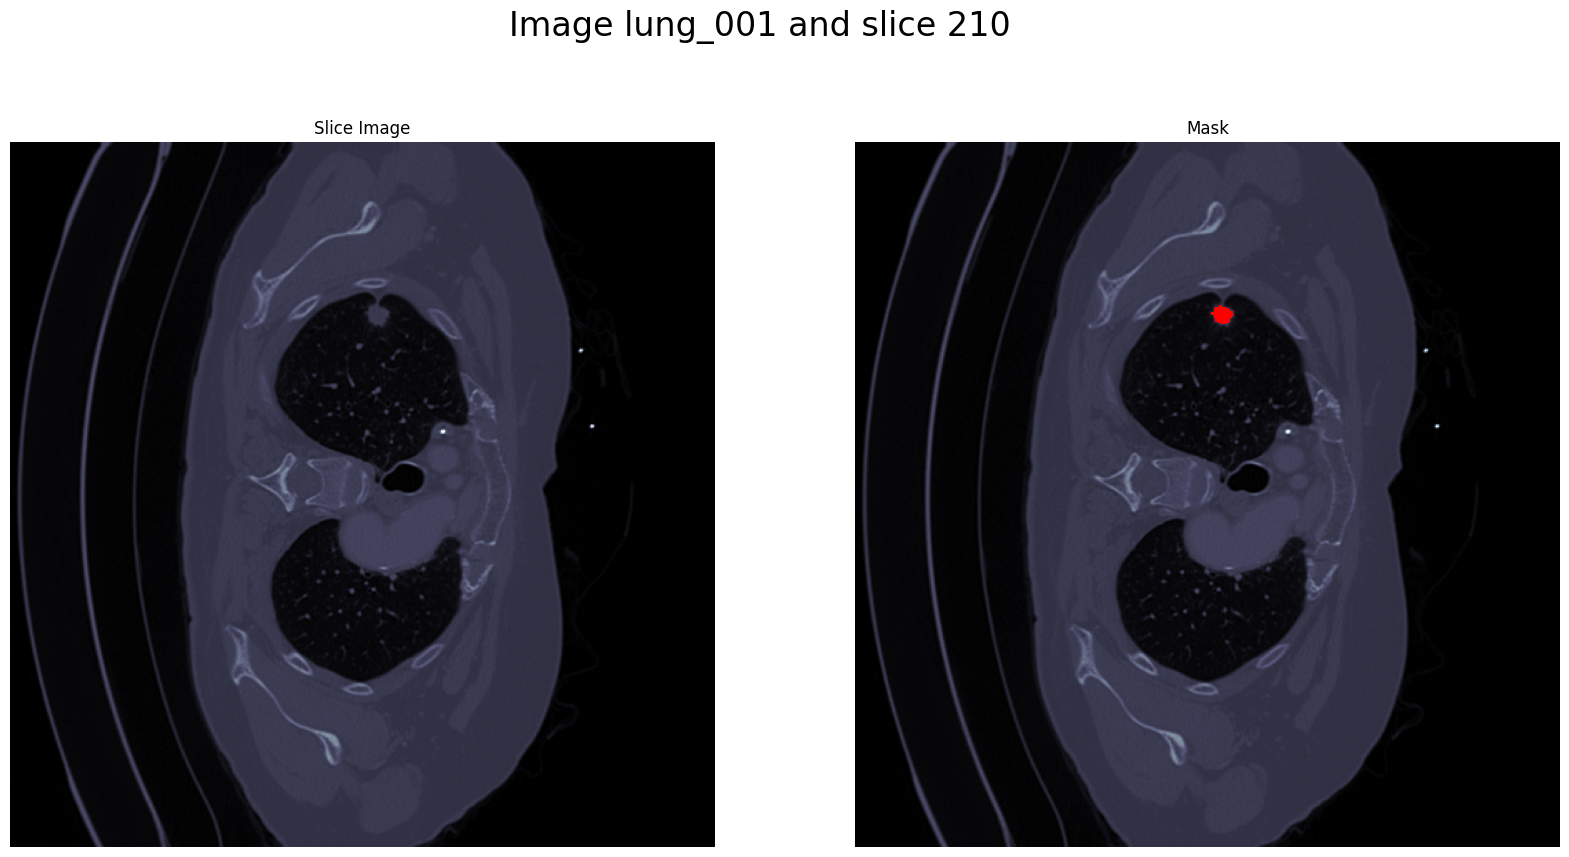

In [ ]:
#Định nghĩa một hàm cho việc hiển thị một slide thông qua id của lung và số thứ tự của slide
def VisualizeSlice(cfg,lung_id,slide_id):
  image_path=f"{cfg['DIR_PREPROCESS']}/images/{lung_id}/{slide_id}.npy"
  mask_path=f"{cfg['DIR_PREPROCESS']}/masks/{lung_id}/{slide_id}.npy"

  ##### TODO 3: Với image_path, mask_path chứa đường dẫn của slice và mask tương ứng lưu trữ ở dạng npy             ######
  ##### Hãy viết code hoàn thiện hàm này để có thể hiện thị ảnh slice và ảnh slice có mask phổi dược overlay trên nó######
  # BEGIN SOLUTION
  slice = np.load(image_path)
  mask = np.load(mask_path)
  # END SOLUTION

  #Hiển thị image và mask
  fig=plt.figure(figsize=(2*10,1*10))
  fig.suptitle(f"Image {lung_id} and slice {slide_id}",fontsize=24)
  plt.subplot(1,2,1)
  plt.title("Slice Image")
  plt.axis('off')
  plt.imshow(slice, cmap="bone")
  plt.subplot(1,2,2)
  plt.title("Mask")
  plt.axis('off')
  mask_ = np.ma.masked_where(mask==0, mask)
  plt.imshow(slice, cmap="bone")
  plt.imshow(mask_, cmap="autumn")
  plt.show()

#Hiển thị lung_001 và slice thứ 210 của nó.
VisualizeSlice(cfg,'lung_001',210)

#BƯỚC 03: CHUẨN BỊ DATALOADER CHO TRAIN, VAL, TEST DATA

In [ ]:
#Chia tập dữ liệu train-val-test với tỉ lệ 80:10:10 trên một sample lung CT (không phải trên slide), với random seed là 2024, chỉ chứa các id của lung data
data=sorted(os.listdir(f"{cfg['DIR_PREPROCESS']}/images"))

train_data, val_test_data = train_test_split(data, test_size=0.2, random_state=2024)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=2024)
print("- Number of train data:",len(train_data),train_data )
print("- Number of val data:",len(val_data),val_data)
print("- Number of test data:",len(test_data),test_data)

- Number of train data: 50 ['lung_023', 'lung_025', 'lung_074', 'lung_038', 'lung_027', 'lung_014', 'lung_069', 'lung_080', 'lung_029', 'lung_096', 'lung_033', 'lung_083', 'lung_064', 'lung_041', 'lung_006', 'lung_084', 'lung_031', 'lung_073', 'lung_045', 'lung_009', 'lung_079', 'lung_062', 'lung_036', 'lung_049', 'lung_066', 'lung_042', 'lung_057', 'lung_016', 'lung_058', 'lung_095', 'lung_044', 'lung_020', 'lung_047', 'lung_078', 'lung_070', 'lung_046', 'lung_055', 'lung_093', 'lung_004', 'lung_018', 'lung_053', 'lung_003', 'lung_061', 'lung_081', 'lung_054', 'lung_043', 'lung_001', 'lung_048', 'lung_086', 'lung_015']
- Number of val data: 6 ['lung_005', 'lung_071', 'lung_034', 'lung_051', 'lung_022', 'lung_010']
- Number of test data: 7 ['lung_059', 'lung_065', 'lung_075', 'lung_026', 'lung_092', 'lung_028', 'lung_037']


In [ ]:
#Tạo đối tượng bộ dữ liệu LungNoudledataset tổng quát để hỗ trợ cho các đối tượng load dữ liệu của train,val,test

##### TODO 4: Hoàn thiện lớp LungNoduleDataset cho phép tích hợp tăng cường dữ liệu ảnh (slice) và mask. Lưu ý khi biến đỗi thì slice và mask phải cùng phép đổi tương ứng                               ######
##### Gợi ý:Tham khảo imgaug tại https://imgaug.readthedocs.io/en/latest/index.html                                                                                                                      ######
##### Gợi ý:Tham khảo albumentations tại https://albumentations.ai/                                                                                                                                      ######
##### Lưu ý:Code sửa đổi và viết thêm có thể bất cứ vị trí nào trong cell này. Ngoài ra, thay đổi kích thước các slice và mask đơn thành (cfg['IMAGE_SIZE'], cfg['IMAGE_SIZE']) để làm đầu vào của model.######                                                                                                       ######



class LungNoduleDataset(Dataset):

  def __init__(self, data, cfg, mode="train",augmentation_data=True,normalization=True):

    self.cfg=cfg
    self.normalization=normalization
    self.augmentation_data=augmentation_data
    self.image_paths = []
    self.mask_paths = []

    if mode == "test":
        self.image_size=cfg['IMAGE_SIZE_TEST']
    else:
        self.image_size=cfg['IMAGE_SIZE']

    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    #Thiết lập một số thông tin tăng cường dữ liệu cho một số phép biến đổi căn bản Flip, Rotate, Scale, Translate
    #Gợi ý: các hàm có thể sử dụng từ thư viện iaa (imgaug) như Fliplr(), Affine(), ElasticTransformeation()... và các hàm khác theo đề xuất của bạn
    # BEGIN SOLUTION
    self.augment_params=iaa.Sequential([
        iaa.Fliplr(0.5), # Horizontal Flips

        # sometimes wrapper object means to apply the transformations for just some of the images
        sometimes(iaa.Crop(percent=(0, 0.1))), # Randomly crop the 0 - 10% of the pixels on four sides, then resize the image back to original

        # random std of the kernl in range 0-0.5, light blur
        sometimes(iaa.GaussianBlur(sigma=(0, 0.2))),

        sometimes(iaa.Affine(
            scale={"x" : (0.8, 1.2), "y": (0.8, 1.2)}, # Scale the image some random amount from 80-120%, axis-dependent
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, #Translate in each direction, axis-independent
            rotate=(-25, 25), #Rotate from -25 - 25 degrees
            shear=(-15, 15) # Shear from -15 to 15 degrees
        ))
      ])
    # END SOLUTION


    #Nhận tất cả các đường dẫn image và mask từ data
    for sample in data:
        #Lấy thông tin từng slice của mỗi lung sample
        slice_names=sorted(os.listdir(f"{cfg['DIR_PREPROCESS']}/images/{sample}"))
        #Ứng với mỗi slide trên của một sample lưu lại thông tin đương dẫn image và mask
        for slice_name in slice_names:
          self.image_paths.append(f"{cfg['DIR_PREPROCESS']}/images/{sample}/{slice_name}")
          self.mask_paths.append(f"{cfg['DIR_PREPROCESS']}/masks/{sample}/{slice_name}")


  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, index):
      # Đọc image slice
      image_path = self.image_paths[index]
      slice = np.load(image_path)                     #WxH
      slice = cv2.resize(slice, (self.image_size,self.image_size))

      # Đọc mask
      mask_path = self.mask_paths[index]
      mask = np.load(mask_path)                       #WxH
      mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

      if self.augmentation_data:                      #Nếu có yêu cầu tăng cường dữ liệu
        # Viết xử lý tăng cường dữ liệu đã khai báo ở phần Thiết lập một số thông tin tăng cường dữ liệu
        # BEGIN SOLUTION
        segmap = SegmentationMapsOnImage(mask.astype(np.uint8), shape=slice.shape)
        slice, segmap = self.augment_params(images=slice, segmentation_maps=segmap)
        mask = segmap.get_arr()
        # END SOLUTION

      if self.normalization:                          #Nếu có yêu cầu chuẩn hoá đầu vào ảnh dữ liệu
        slice=slice/self.cfg["NORMALIZATION_VALUE"]

      slice = np.expand_dims(slice, 0)                #1xWxH        channel first
      mask = np.expand_dims(mask, 0)                  #1xWxH        channel first

      return torch.FloatTensor(slice.copy()), torch.FloatTensor(mask),self.image_paths[index]

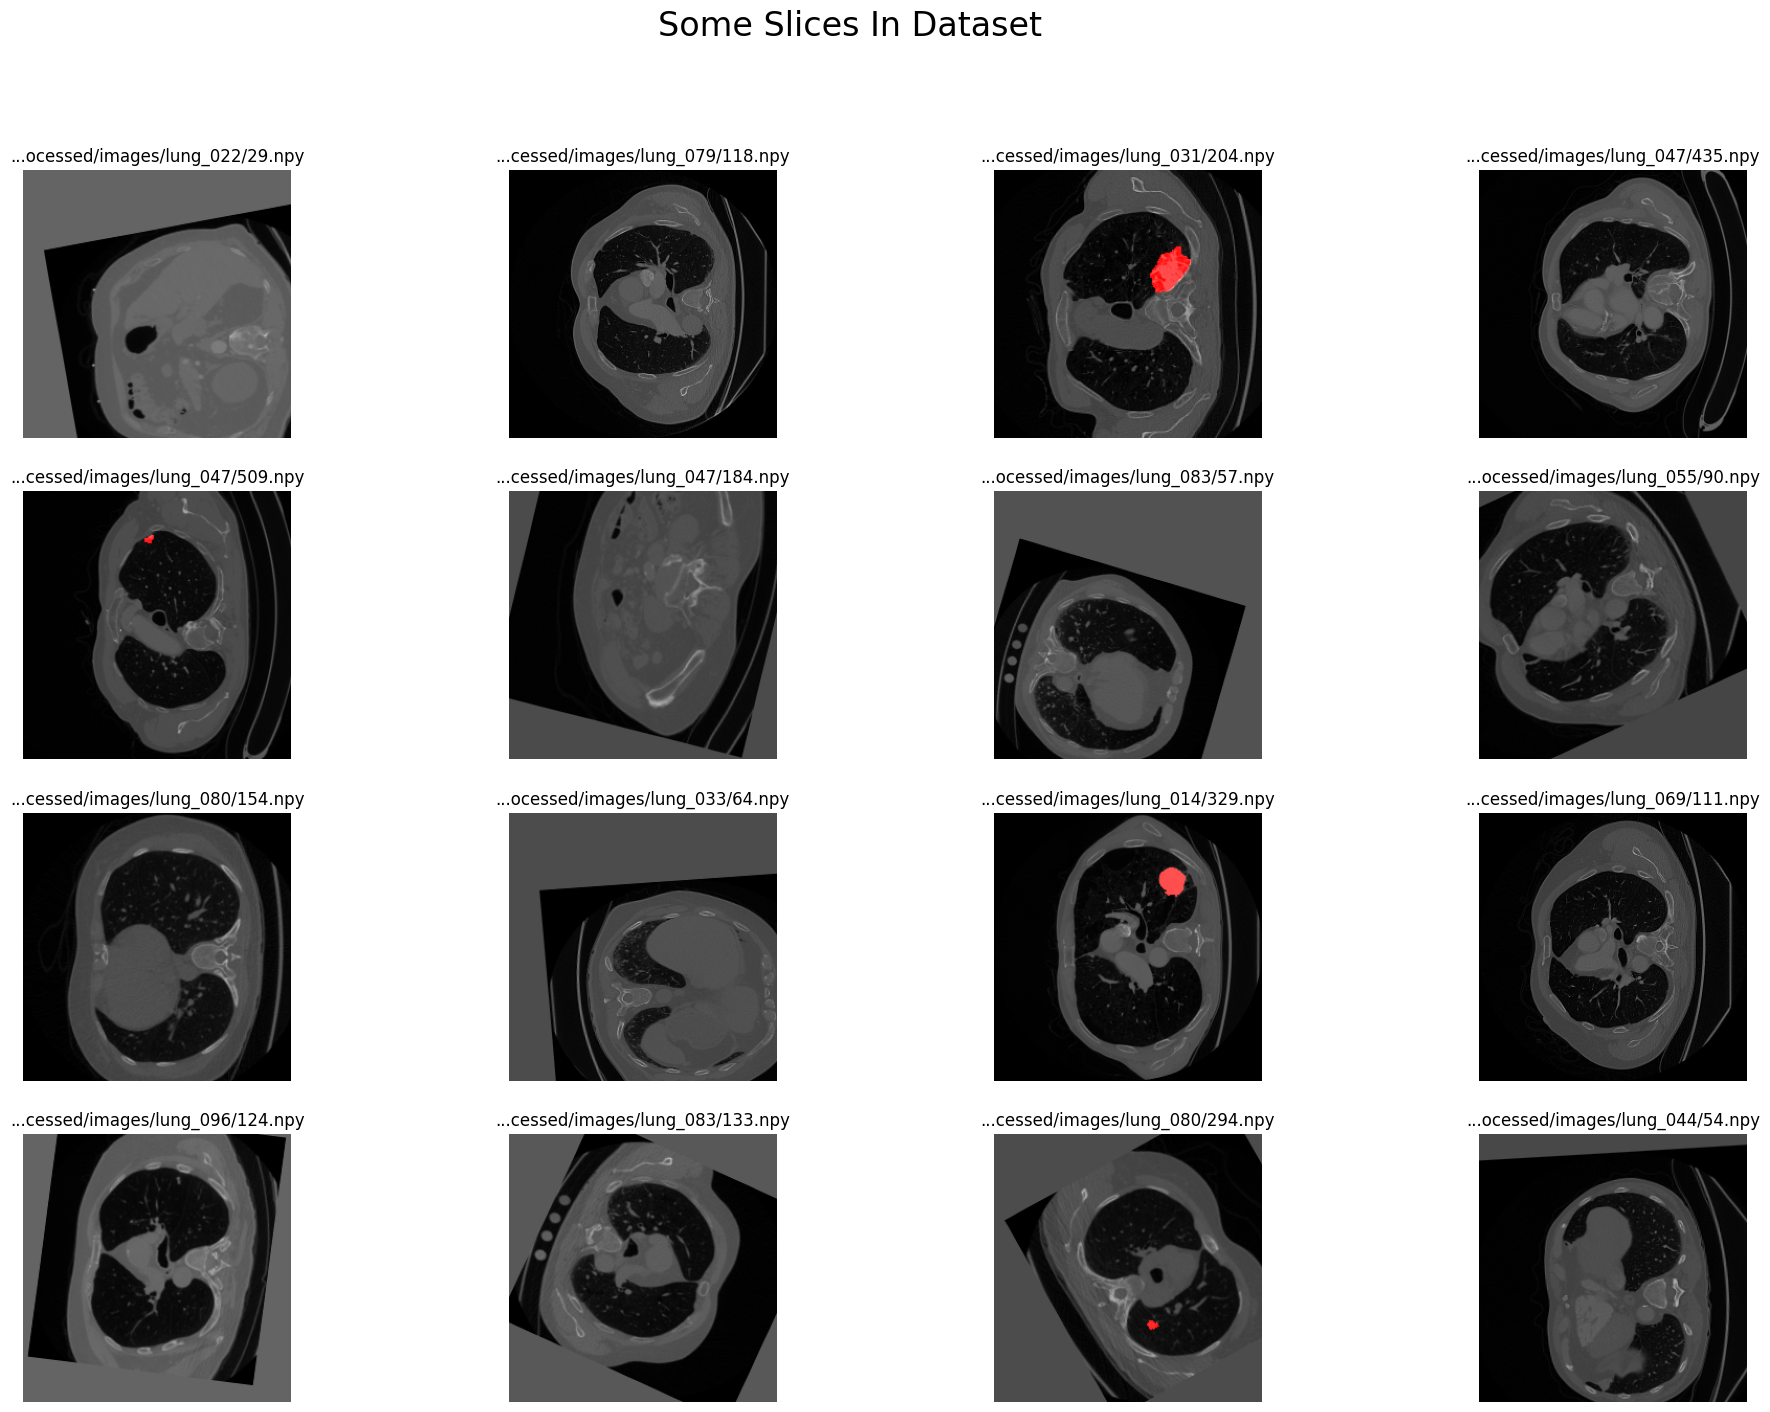

In [ ]:
#Tạo ảnh lát cắt với các lung nodule được overlay

##### TODO 5: Hoàn thiện hàm DrawImage cho phép nhận vào một ảnh và mask                                            ######
##### Thực hiện vẽ overlay mask lên ảnh, kết quả trả về là một ảnh image_output dùng để hiển thị sử dụng matplotlib ######
##### Phạm vi viết code là trong cell này, có thể khai báo các hàm phụ tuỳ ý                                        ######


# Scaling array với giá trị âm đến ngưỡng nhỏ nhất, lớn nhất: min=0 and max=1
def scale_array(arr, min_val=0, max_val=1):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    scaled_arr = (arr - arr_min) / (arr_max - arr_min) * (max_val - min_val) + min_val
    return scaled_arr

def DrawImage(image_tensor, mask_tensor):
  image = image_tensor.clone().detach().cpu().numpy().squeeze()
  image = scale_array(image)
  mask = mask_tensor.clone().detach().cpu().numpy().squeeze()

  # print(f'Image Dimenson: {image.shape}')
  # print(f'Mask Dimension: {mask.shape}')

  #Viết giải pháp của bạn tại đây
  # BEGIN SOLUTION
  image_3channel= np.stack([image]*3, axis=-1)     #Để hiển thị màu chúng ta cần 3 kênh màu C x H x W

  overlay_mask = np.zeros_like(image_3channel)     #WxHxC chuyển kênh màu về cuối để dễ sử dụng broadcast trên pixel
  overlay_mask[mask==1] = [255, 0, 0]                           #màu đỏ
  image_output = cv2.addWeighted(image_3channel, 0.7, overlay_mask, 0.3, 0)
  return image_output


#Tạo dataloader cho tất cả dữ liệu và hiển thị một số ví dụ
data_dataset = LungNoduleDataset(data, cfg, mode="train",augmentation_data=True,normalization=False)
data_dataloader = DataLoader(dataset=data_dataset, batch_size=16, shuffle=True, num_workers=cfg["NUM_WORKER"], pin_memory=True)

#Kiểm tra kích thước của data và label cho mỗi lần lặp
for images , masks, paths in data_dataloader:
  nums_img=images.shape[0]
  cols=4
  rows=nums_img//cols
  fig=plt.figure(figsize=(cols*6,rows*4))
  fig.suptitle("Some Slices In Dataset ",fontsize=24)
  for i in np.arange(rows):
    for j in np.arange(cols):
      index=(i*cols)+j
      path=paths[index]
      image_tensor=images[index]
      mask_tensor=masks[index]
      img=DrawImage(image_tensor,mask_tensor)
      plt.subplot(rows,cols,index+1)
      plt.title("..."+path[-30:])
      plt.imshow(img)
      plt.axis('off')
  plt.show()
  break


In [ ]:
#Tạo dataloader cho Train-Val-Test

train_dataset = LungNoduleDataset(train_data, cfg, mode="train",augmentation_data=True,normalization=cfg['NORMALIZATION'])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=True, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Number of train data slices:{len(train_dataset)}")

val_dataset = LungNoduleDataset(val_data, cfg, mode="val",augmentation_data=False,normalization=cfg['NORMALIZATION'])
val_dataloader = DataLoader(dataset=val_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=False, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Number of val data slices:{len(val_dataset)}")

test_dataset = LungNoduleDataset(test_data, cfg, mode="test",augmentation_data=False,normalization=cfg['NORMALIZATION'])
test_dataloader = DataLoader(dataset=test_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=False, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Test data sliced:{len(test_dataset)}")


-Number of train data slices:12746
-Number of val data slices:1613
-Test data sliced:1408


#BƯỚC 04: ĐỊNH NGHĨA MODEL PHÂN ĐOẠN NGỮ NGHĨA UNET

In [ ]:
##### TODO 6: Hoàn thiện code trong cell này, xây dựng mô hình Unet căn bản UnetSegmentationModel, cho phép nhận một ảnh đầu vào 1xWxH (CT slice) và trả ra kết quả phân đoạn ngữ nghĩa đầu ra tương ứng        ######
##### với khích thước 1xWxH (về độ phân giải đầu vào và đầu ra là giống nhau WxH, số lượng channel đầu ra là 1, tương ứng là binary mask)                                                                       ######
##### Nhiệm vụ: hoàn thiện xử lý forward cho mô hình UNET, một số moduel như unetConv2 và unetUp đã được cung cấp sẵn                                                                                           ######
##### Nâng cao: có thể vận dụng một số kỹ thuật phực tạp từ các paper như CCBANet, PraNet, ACSNet...                                                                                                            ######

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1), nn.ReLU())
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1), nn.ReLU()
            )

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        #print (outputs.shape)
        outputs = self.conv2(outputs)
        #print (outputs.shape)
        return outputs

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, is_batchnorm):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)

        return self.conv(torch.cat([outputs1, outputs2], 1))

class UnetSegmentationModel(nn.Module):
    def __init__(self,in_channels, num_classes, cfg):
        """
        Init model architecture

        Parameters
        ----------
        num_classes: int
            number of classes
        cfg: dictionary
            hyper-parameters config
        """
        super().__init__()

        self.in_channels=in_channels
        self.num_classes=num_classes
        self.cfg=cfg

        #Some config for UNET model
        self.is_batchnorm = True
        self.feature_scale=2
        self.is_deconv = True             #Sử dụng Deconvolution hay Upsample layer
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        #DEFINE UNET MODEL
        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv, self.is_batchnorm)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv, self.is_batchnorm)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv, self.is_batchnorm)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv, self.is_batchnorm)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], self.num_classes, 1)

    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        # BEGIN SOLUTION
        #Gợi ý: Tính nhánh encoder của Unet, ứng với mỗi tầng sẽ đi qua một conv1 và một maxpool, sẽ đi qua 4 tầng. Bên dưới là ví dụ tầng đầu tiên
        #conv1 = self.conv1(inputs)
        #maxpool1 = self.maxpool1(conv1)
        #Sau đó sẽ đi qua bottleneck module self.center
        #Tiếp theo sẽ lần lượt đi qua 4 tầng bên nhánh decoder để giải mã thông tin, Bên dưới là ví dụ tầng đầu tiên
        #up4 = self.up_concat4(conv4, center)
        #Do kết quả cần thu là binary mask, trong ngưỡng giá trị [0..1] chúng ta cần chuyễn chúng vào hàm sigmoid.
        #final = F.sigmoid(self.final(up1))
        #...
        # END SOLUTION

        return final

In [ ]:
#Khai báo mô hình
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnetSegmentationModel(in_channels=1, num_classes=1, cfg=cfg).to(device)                       # Mỗi slice input đầu vào có 1 kênh grayscale, đầu ra là binary mask
print(model)
print("Number of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

UnetSegmentationModel(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

#BƯỚC 05: ĐỊNH NGHĨA LOSS FUNCTION, METRICS, OPTIMIZER, SCHEDULE

Intersection over Union (IOU)/Jaccard index là độ đo tiêu chuẩn và độ tin tin cậy cho các bài toán phân đoạn. Đó là vùng giao giữa phân đoạn được dự đoán của mô hình (predicted) và nhãn đúng (ground-truth) chia cho vùng hợp giữa chúng.

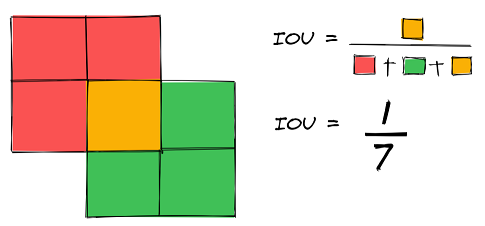

In [ ]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=cfg['LEARNING_RATE'], betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate sẽ giảm tự động trong khi training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = cfg["ReduceLROnPlateau"]["LEARNING_RATE_SCHEDULE_FACTOR"] , patience = cfg["ReduceLROnPlateau"]["LEARNING_RATE_SCHEDULE_PATIENCE"], mode = 'max')


##### TODO 7: Hoàn thiên hàm iou_metrics(pred, target) tính IOU cho kết quả mô hình tiên đoán pred (BSxCxWxH) và ground-truth target (BSxCxWxH), trong đó C tương ứng là 1 (binary mask ######
##### ious trả về là mảng chứa các iou của từng ảnh trong một batch                                                                                                                     ######
def iou_metrics(pred, target):
    b,c,w,h=target.shape
    target = (target.to("cpu").numpy() > 0.5).astype(float).reshape(b,c*w*h)            #c=1
    pred = ((pred.to("cpu").numpy() > 0.5) * 1.0).astype(float).reshape(b,c*w*h)        #c=1
    #Viết giải pháp của bạn tại đây
    # BEGIN SOLUTION
    intersection =
    union =
    ious =
    # END SOLUTION
    return ious


#BƯỚC 06: ĐỊNH NGHĨA CÁC BƯỚC CƠ SỞ ĐỂ TRAIN, VALID VÀ TEST

In [ ]:
#Train phase
def train_epoch(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):

    # Chuyển model sang training mode
    model.train()
    training_loss = 0 # Lưu trữ tổng của training losses

    # Với mỗi batch
    for batch, (images, masks, _) in enumerate(progress_bar(train_dataloader, parent=mb)):

        # Di chuyển images, masks đến device (GPU)
        images = images.to(device)
        masks = masks.to(device)

        # Xóa gradient trước
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, masks)

        # Back propagation
        loss.backward()

        # Cập nhât parameters
        optimizer.step()

        # Cập nhât training loss sau mỗi batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, masks, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # Trả lại training loss
    return training_loss/len(train_dataloader)

In [ ]:
#Evaluation phase
def evaluation_epoch(epoch, model, val_dataloader, device, loss_criteria, mb):

    # Chuyển model sang training mode
    model.eval()

    val_loss = 0                                   # Tổng loss của model trên validation set
    ious=[]

    with torch.no_grad(): # Tắt gradient
        # Với mỗi batch
        for step, (images, masks, _) in enumerate(progress_bar(val_dataloader, parent=mb)):
            # Di chuyển images, masks đến device (GPU)
            images = images.to(device)
            masks = masks.to(device)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, masks)

            ious.append(iou_metrics(ps,masks))

            # Cập nhât validation loss sau mỗi batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Xóa bộ nhớ
    del images, masks, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # Trả lại validation loss và metric score

    return val_loss/len(val_dataloader), np.concatenate(ious, axis=0).mean()

In [ ]:
# Lưu model có IOU tốt nhất trong quá trình huấn luyện
def full_training(model,save_path,max_epochs,train_dataloader,val_dataloader,optimizer,loss_criteria,lr_scheduler,device):
  best_score = 0
  training_losses = []
  validation_losses = []
  validation_score = []


  # Config progress bar
  mb = master_bar(range(max_epochs))
  mb.names = ['Training loss', 'Validation loss', 'Validation IOU']
  x = []

  # Training mỗi epoch
  for epoch in mb:
      mb.main_bar.comment = f'Best IOU score: {best_score}'
      x.append(epoch)

      # Train
      train_loss = train_epoch(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
      mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
      training_losses.append(train_loss)

      # Evaluate
      val_loss,new_score = evaluation_epoch(epoch, model, val_dataloader, device, loss_criteria, mb)
      mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
      validation_losses.append(val_loss.to("cpu").numpy())
      validation_score.append(new_score)

      # Cập nhật learning rate
      lr_scheduler.step(new_score)

      # Cập nhật training chart
      mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,max_epochs], [0,1])

      # Lưu model
      if best_score < new_score:
          mb.write(f"Improve IOU from {best_score} to {new_score}")
          best_score = new_score

          # Lưu model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
          torch.save(model.state_dict(), save_path)

In [ ]:
##### TODO 8: test_phase cho phép chạy mô hình UNET và lấy kết quả IOU trên tập test, hàm này sẽ được sử dụng ở bước 8             ######
##### Gợi ý: Hàm này viết hoàn toàn tương tự như hàm evaluation_epoch(), tuy nhiên chỉ cần tính giá trị trung bình iou cần trả về. ######

#Test phase
def test_phase(model, val_dataloader, device, loss_criteria):
    #Viết giải pháp của bạn tại đây
    # BEGIN SOLUTION
    #...
    #...
    #...
    # END SOLUTION
    return np.concatenate(ious, axis=0).mean()

#BƯỚC 7: HUẤN LUYỆN MÔ HÌNH

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


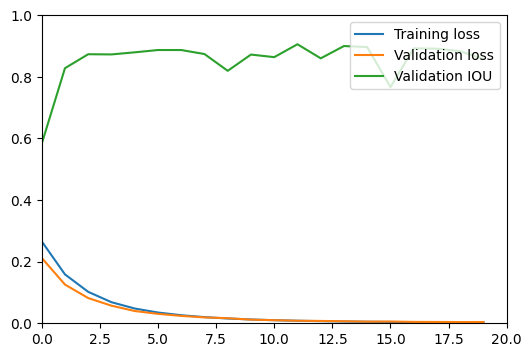

In [ ]:
save_path = "./thebestmodel.pth"
full_training(model,save_path,cfg['MAX_EPOCHS'],train_dataloader,val_dataloader,optimizer,loss_criteria,lr_scheduler,device)

#BƯỚC 8: KIỂM CHỨNG TRÊN TẬP TEST

In [ ]:
#Load model tốt nhất trên tập và và chạy cho tập test
state = torch.load('thebestmodel.pth', map_location=device)
model.load_state_dict(state)
model.eval()
iou_score=test_phase(model, test_dataloader, device, loss_criteria)
print(f"AUO on the test set:{iou_score}")

0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22
IOU on the test set:0.8784926798091335


# BƯỚC 9: PHÂN ĐOẠN NỐT PHỔI TRÊN MỘT ẢNH CT PHỔI VÀ HIỂN THỊ KẾT QUẢ PHÂN ĐOẠN




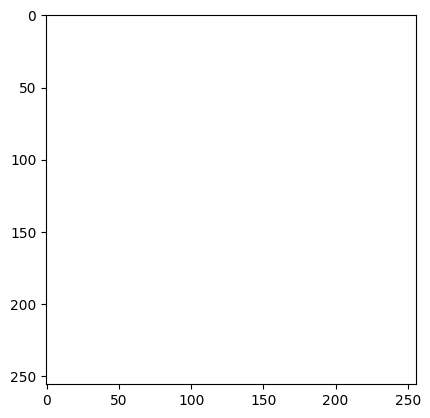

In [ ]:
##### TODO 9: Hoàn thiện hàm get_prediction, cho phép nhận đường dẫn của một lung sample, model, kích thước ảnh đầu vào lưu tại cfg["IMAGE_SIZE_TEST"]     ######
##### kết quả của hàm trả về là dãy các ảnh grayscale 'output_slices' các ảnh có kích thước WxH và dãy 'output_masks' có kích thước WxH, hai kết quả này sẽ######
##### đợc sử dụng để visualize kết quả bởi hàm ViualizeLungAndMask(slices,masks)                                                                           ######

def get_prediction(model,lung_path,cfg):
    ct_data = nib.load(lung_path).get_fdata()
    output_slices=[]
    output_masks=[]
    with torch.no_grad():
      for i in range(ct_data.shape[-1]):
          slice = ct_data[:,:,i]

          #Viết giải pháp của bạn tại đây
          # BEGIN SOLUTION

          #Rezie ảnh dùng cv2 theo kích thước định nghĩa tại cfg["IMAGE_SIZE_TEST"]
          #Copy slice dùng deepcopy và them có output_slices
          #Kiểm tra xem cfg['NORMALIZATION'] có cần chuẩn hoá dữ liệu thì chuẩn hoá cho slice
          #Tạo slice_tensor là slice được tăng chiều chiều cho batch và channel từ WxH -> 1x1xWxH để nạp vào mô hình
          #Chuyển slice_tensor vào GPU
          #Nap vào model tính kết quả predict của mô hình, kết quả sẽ có kích thước là 1X1xWxH
          #Copy kết quả và chuyển sang bộ nhớ cpu để bắt đầu rút trích kết quả
          #Kết quả sẽ được biến đổi thành giá trị binary 0 hoặc 1, dựa trên ngưỡng theshold là 0.5
          #Lấy mask WxH từ 1x1xWxH của kết quả cuối tính được và nạp vào output_masks

          # END SOLUTION
    return output_slices,output_masks

def ViualizeLungAndMask(slices,masks):
  fig = plt.figure()
  camera = Camera(fig)  # Tạo đối tượng camera để capture dãy các slice
  for i in np.arange(len(slices)):
      plt.imshow(slices[i], cmap="bone")
      mask_ = np.ma.masked_where(masks[i]==0, masks[i])
      plt.imshow(mask_, alpha=0.5, cmap="autumn")
      camera.snap()  # Lưu trữ slice hiện tại
  animation = camera.animate()  # Tạo animation
  return animation

#Load model tốt nhất và chạy cho một ảnh
lung_path=f"./Decathlon_LungNoduleDataset/imagesTr/{test_data[3]}.nii.gz"
state = torch.load('thebestmodel.pth', map_location=device)
model.load_state_dict(state)
model.eval()

output_slices,output_masks=get_prediction(model,lung_path,cfg)
animation=ViualizeLungAndMask(output_slices,output_masks)
HTML(animation.to_html5_video())


###Tham khảo thêm
Chúc mừng các bạn đã hoàn thành bài tập!
Giải pháp cho bài toán này là dùng mô hình 2D đê giải quyết bài toán phân đoạn dữ liệu 3D. Do giới hạn tài nguyên tính toán và độ phức tập nên hiện nay cách tiếp cận này vẫn đang phổ biến.

Tuy nhiên, giải pháp dùng chính mô hình 3D cũng có nhiều ưu thế, chính vì thế các bạn có thể nâng cao kiến thức của mình bằng cách tìm hiểu về nó. Và sau đây là 2 paper về dùng 3D CNN để phân đoạn nốt phổi trên ảnh CT 3D, các bạn có thể đọc đó để bắt đầu:

[1] Tang, H., Zhang, C., Xie, X. (2019). NoduleNet: Decoupled False Positive Reduction for Pulmonary Nodule Detection and Segmentation. In: Shen, D., et al. Medical Image Computing and Computer Assisted Intervention – MICCAI 2019. MICCAI 2019. Lecture Notes in Computer Science(), vol 11769. Springer, Cham. https://doi.org/10.1007/978-3-030-32226-7_30

[2] Nguyen, T. C., Nguyen, T. P., Cao, T., Dao, T. T. P., Ho, T. N., Nguyen, T. V., & Tran, M. T. (2023). MANet: Multi-branch attention auxiliary learning for lung nodule detection and segmentation. Computer methods and programs in biomedicine, 241, 107748. https://doi.org/10.1016/j.cmpb.2023.107748